Consider making a more useful state. He uses
-- [AAPL holdings, 
MSFT holdings, 
cash, 
current timestep's AAPL opening price, 
current timestep's MSFT opening price, 
current portfolio value, 
past 5 day average AAPL opening price, 
past 5 day average MSFT opening price]. https://towardsdatascience.com/a-blundering-guide-to-making-a-deep-actor-critic-bot-for-stock-trading-c3591f7e29c2

Consider normalizing the data also. Reward function also probably needs a change. In the article they say The step reward needed to be a balance of how long the bot has survived plus how much gain it has made. Without this the bot will most likely either try to just survive or just maximize profits but not both

In [1]:
import pandas as pd
import quandl
import datetime

In [1]:
#We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2001,1,1)
end = datetime.datetime(2006,12,31)

In [111]:
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)

In [112]:
apple = apple.reset_index()[["Date","Open","High","Low","Close","Adj. Close","Volume"]]

In [2]:
apple = pd.read_csv("stock_data.csv")
apple.head()
apple["Close"].mean()

36.12617544790976

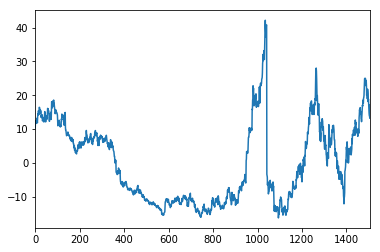

In [15]:
from scipy import signal
msf_close = signal.detrend(apple["Close"])
pd.Series(msf_close).plot()

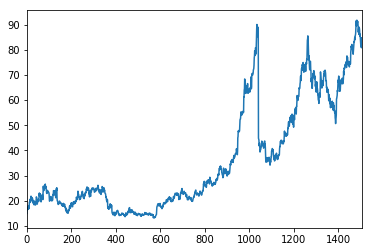

In [3]:
%matplotlib inline
apple["Close"].plot()

In [5]:
apple.to_csv("stock_data.csv", index = False)
apple.head()

In [3]:
#make our agent
import numpy as np
import random
class DQN:
    #this sets up the bolltmann parameters
    def __init__(self, env):
        self.env     = env
        #can hold 1000 sequences at most
        self.memory  = deque(maxlen=1000)
        
        self.gamma = 0.85
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.tau = .125

        self.model        = self.create_model()
        self.target_model = self.create_model()

    #This creates our model
    def create_model(self):
        model   = Sequential()
        state_shape  = 7 #for now assume window size is 7
        model.add(Dense(24, input_dim=state_shape, activation="relu"))
        model.add(Dense(48, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(3))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model
    
    #This is the exploration vs exploitation part. sample() gives us our 1 of 3 action choices. Actually take the action
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return random.randint(0,2)
        return np.argmax(self.model.predict(state.values.reshape(1,7))[0])

    #puts the current trial in memory so we can sample from it later and use it
    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    #sample our paths from memory and fit them to get current and future state rewards
    def replay(self):
        batch_size = 32
        
        if len(self.memory) < batch_size: #don't let it sample from a spot where we don't have at least 5 options
            return

        samples = random.sample(self.memory, batch_size) #samples 5 observations from memory
        #here is where we update our 'q' values. Since we are using a model we don't have a q table, rather we y values
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state.values.reshape(1,7)) #predicts all 3 options in an array
            if done:
                target[0][action] = reward #if we win/end then there are no more terminal states so we know the reward we will get
            else:
                #otherwise choose the the max Q for estimating future reward
                Q_future = max(self.target_model.predict(new_state.values.reshape(1,7))[0]) 
                target[0][action] = reward + Q_future * self.gamma #Boltzmann Equation

            #fit a model to your max possible target (gain) value
            
            #This keeps changing your weights of your neural network based on your new target values each time
            self.model.fit(state.values.reshape(1,7), target, epochs=1, verbose=0)

    #updates the training weights
    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            #update training weights as explained in the blog for convergence
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

In [4]:
import numpy as np
stock_close = pd.Series(apple["Close"])
stock_close.shape

(1507,)

In [87]:
#we will need to make our environment with a class
from gym.utils import seeding
from gym import spaces

class stock_env:
    def __init__(self):
        
        self.observation = 0
        self.observation_space = spaces.Discrete(3)
        self.guess_max = 30 #30 this is our choice. how long do we want it to be able to look until we cut the trial?
        self.ending_value = 0
        self.starting_value = 0
        self.counter = 0
        self.zero_counter = 0
        self.seed()
        self.reset()
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action,counter, num_stocks, money_sum):
     
        #other
        if action == 0:
            self.observation = 0
            money_sum = money_sum*.995 #extra penalty for doing nothing
            reward = money_sum - zero_counter
        #add a rule in to stop it from doing this every single time
            if zero_counter == self.guess_max:
                reward = -1
                return 0, reward, True, num_stocks, reward
            
        #buy
        if action == 1:
            self.observation = 1
            num_stocks = num_stocks + 1 #this is the number of more stocks you have
            money_sum = money_sum - list(stock_close)[end_ts + counter]
            reward = money_sum - zero_counter
            
            if (money_sum < 0) & (action == 1): #slightly repetitive but good intuition
                reward = -1 
                return 1, money_sum , True, num_stocks, reward
            
        #sell
        if action == 2:
            self.observation = 2
            num_stocks = num_stocks - 1 #this is the number of more stocks you have
            money_sum = money_sum + list(stock_close)[end_ts + counter] #remove the interchange fee for now
            reward = money_sum - zero_counter
            
            if num_stocks < 0:
                reward = -1
                return 2, reward, True, num_stocks, reward
            
        
        #reward = money_sum
        #takes counter from our for loop. We will only go 20 observations at a time so it doesn't learn time spanned bias
        done = counter >= self.guess_max
        return self.observation, money_sum, done, num_stocks, money_sum
    
    #ideally this should be random every time but it couldn't learn well so now going to restart at the same point every time
    def reset(self):
        from random import randint
        self.observation = 0
        ending_value = len(stock_close) - 1    #randint(30, len(stock_close) - 1) #can end on any number that has at least 30 days of history
        starting_value = 7 #ending_value - 30
        self.counter = 0
        self.zero_counter = 0
        num_stocks = 2 #start with 5 stocks available to buy
        money_sum = 200 #start with 500 dollars as if we start at a weird point a stock can cost $90
        return self.observation, ending_value, starting_value, self.counter, num_stocks, money_sum, self.zero_counter

In [105]:
#initiazlied parameters... still need to create environment
env = stock_env
gamma   = 0.9
epsilon = .95
trials  = 500

In [106]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
dqn_agent = DQN(env)

Need to redefine a better reward function

In [107]:
#collect results
reward_list = []
num_stocks_list = []

In [ ]:
#start point has to have at least 7 days of previous information till the end

#here is how we loop through our states
for trial in range(trials):
    
    #get initial parameters
    observation, ending_value, starting_value, counter, num_stocks, money_sum, zero_counter = stock_env.reset(stock_env)   
    
    end_ts = starting_value + 7
    zero_counter = 0
    #loop goes a variable number of days so it doesn't learn to only go in a specific pattern
    for i in range(starting_value, len(stock_close)-7):  #range(ending_value, len(stock_close)-30) is what we previously did
        current_state = stock_close[starting_value + counter:end_ts + counter]
        current_price = stock_close[end_ts + counter]
        counter += 1

        #make an action... possible options are 0, 1 or 2
        action = dqn_agent.act(current_state)
        
        if action == 0:
            zero_counter += 1
        
        if i == starting_value:
            action = random.randint(0,1)

        #step into the action
        observation, reward, done, num_stocks, money_sum = env.step(env(), action, counter, num_stocks, money_sum)
        
        #print("Counter: ", counter)
        #print("Observation: ", observation)
        #print("Reward: ", reward)
        #print("Num_Stocks: ", num_stocks)
        
        #next state
        next_state = stock_close[starting_value + counter:end_ts + counter]
        
        
        dqn_agent.remember(current_state, action, reward, next_state, done)


        dqn_agent.replay()
        dqn_agent.target_train()
        
        state = next_state
        if done:
            #print("--------------------------------")
            print("Total Profit at {}: ".format(trial) + str(money_sum - 200)) #we started with 500 so looking at our net gain
            #print("Num Stocks: ", str(num_stocks))
            #print("Zero Counter: ", str(zero_counter))
            #print("--------------------------------")
            reward_list.append(str(reward - 200))
            num_stocks_list.append(str(num_stocks))
            break  

Total Profit at 0: -48.326782358445115
Total Profit at 1: -69.83185412662468
Total Profit at 2: -77.18755317366407
Total Profit at 3: -201
Total Profit at 4: -71.26952474300438
Total Profit at 5: -56.917738419369016
Total Profit at 6: -44.02517085291632
Total Profit at 7: -193.57541810542796
Total Profit at 8: -54.24703895647909
Total Profit at 9: -190.15850247368303
Total Profit at 10: -110.50580045181594
Total Profit at 11: -201
Total Profit at 12: -201
Total Profit at 13: -201
Total Profit at 14: -201
Total Profit at 15: -165.76476756240388
Total Profit at 16: -201
Total Profit at 17: -62.319630675320326
Total Profit at 18: -3.920144278490568
Total Profit at 19: -9.26016414201905
Total Profit at 20: -63.22475057820674
Total Profit at 21: -78.8950826531909
Total Profit at 22: -44.793572570299716
Total Profit at 23: -61.740105983432215
Total Profit at 24: -41.49377840147412
Total Profit at 25: -62.8412933869555
Total Profit at 26: -132.4216068148911
Total Profit at 27: -116.0442004950

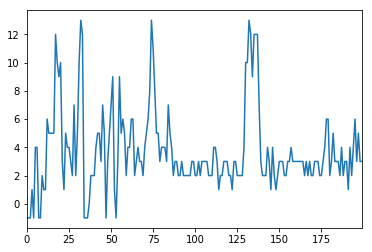

In [80]:
pd.Series(num_stocks_list).astype(float).plot()